# Poincare Boundary Condition

Most of the tutorials use last closed flux surface (LCFS) as the boundary condition for 3D equilibrium. This tutorial will cover another way to define boundary condition using DESC.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

Import required stuff.

In [2]:
%matplotlib inline
import numpy as np

from desc.objectives import (
    ObjectiveFunction,
    ForceBalance,
    get_fixed_xsection_constraints,
    get_fixed_boundary_constraints,
)
from desc.examples import get
from desc.optimize import Optimizer
from desc.plotting import plot_comparison
from desc.geometry import PoincareRZLSection
from desc.equilibrium import Equilibrium

DESC version 0.11.1+736.g71dcdf365.dirty,using JAX backend, jax version=0.4.25, jaxlib version=0.4.25, dtype=float64
Using device: CPU, with 8.72 GB available memory


### Solving Poincare Boundary Condition from an existing equilibrium

To first show that Poincare BC gives the same result with LCFS, let's set our optimization problem by taking the $\zeta$=0 Poincare cross-section of Heliotron equilibrium.

In [3]:
eq = get("HELIOTRON")
zeta = 0
eq_poin = eq.set_poincare_equilibrium(zeta=zeta)
# plot_comparison(eqs=[eq,eq_poin],labels=['LCFS',f'Poincare BC Initial Guess']);

We can also choose $\zeta = \pi$ as the boundary condition and set it from an existing equilibrium.

In [4]:
eq = get("HELIOTRON")
eq_poin = eq.set_poincare_equilibrium()

# plot_comparison(eqs=[eq,eq_poin],labels=['LCFS','Poincare BC Initial Guess']);

In [5]:
print(eq.get_surface_at(zeta=0).L_basis)
print(eq_poin.R_basis)
print(eq.R_basis)

ZernikePolynomial at 0x70b294572150 (L=24, M=12, N=0, NFP=1, sym=sin, spectral_indexing=fringe)
FourierZernikeBasis at 0x70b1a1723080 (L=24, M=12, N=3, NFP=19, sym=cos, spectral_indexing=fringe)
FourierZernikeBasis at 0x70b1a128d370 (L=24, M=12, N=3, NFP=19, sym=cos, spectral_indexing=fringe)


Now, we can solve the newly created 'eq_poin' as usual. The code will apply some checks to see if you are trying to solve a Poincare BC problem or LCFS. Then, add the required constraints and objectives before sending it to the optimizer.

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 127 ms
Timer: Objective build = 547 ms
Building objective: poincare R
Building objective: poincare Z
Building objective: poincare Lambda
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: self_consistency boundary R
Building objective: self_consistency boundary Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section Lambda
Timer: Objective build = 2.24 sec
Timer: Linear constraint projection build = 5.37 sec
Number of parameters: 1521
Number of objectives: 4940
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.073e-01 

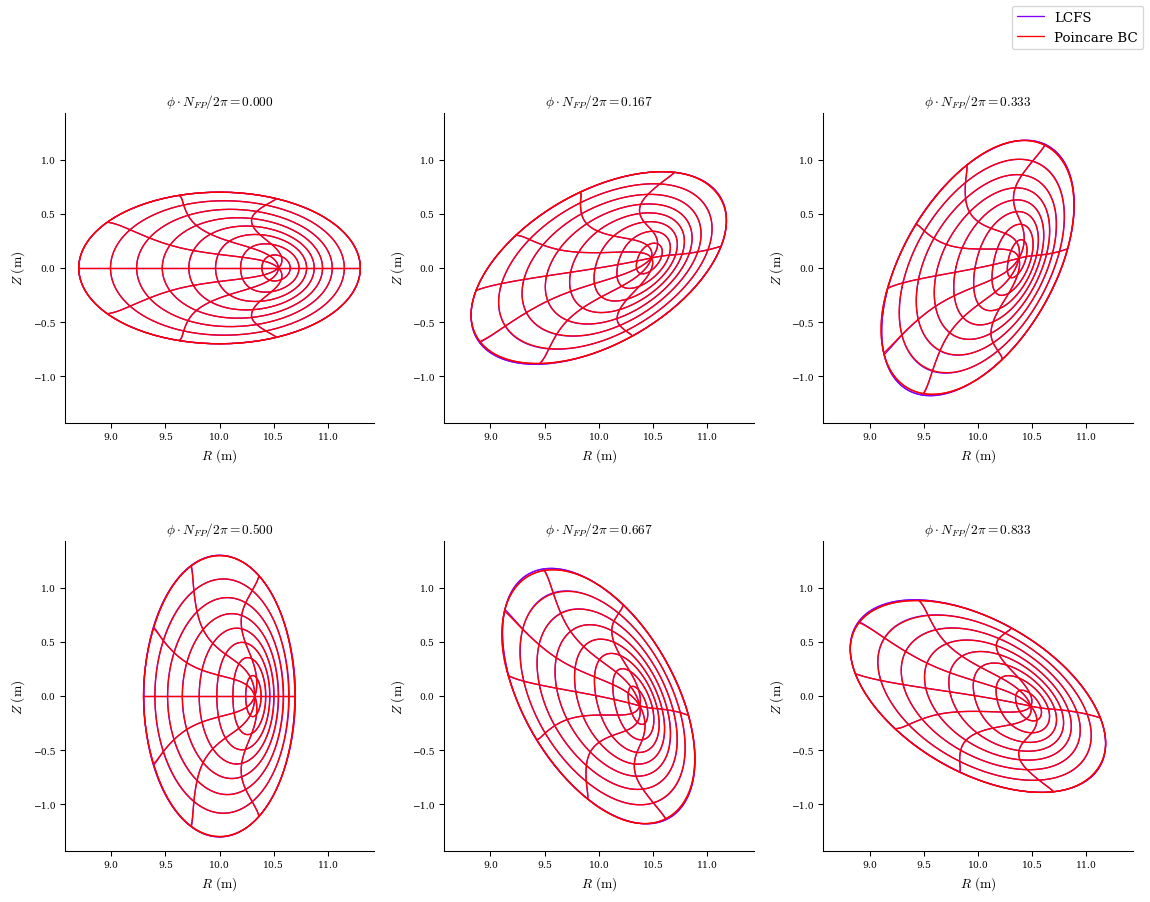

In [9]:
eq = get("HELIOTRON")
eq_poin = eq.set_poincare_equilibrium()

constraints = get_fixed_xsection_constraints(eq=eq_poin)
objective = ObjectiveFunction(ForceBalance(eq_poin))
optimizer = Optimizer("lsq-exact")

eq_poin.solve(verbose=3, ftol=0, objective=objective, constraints=constraints, optimizer=optimizer,maxiter=200, xtol=0)
plot_comparison(eqs=[eq,eq_poin],labels=['LCFS',f'Poincare BC']);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 126 ms
Timer: Objective build = 509 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency boundary R
Building objective: self_consistency boundary Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section Lambda
Timer: Objective build = 2.39 sec
Timer: Linear constraint projection build = 6.78 sec
Number of parameters: 1593
Number of objectives: 4940
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          3.874e-08     

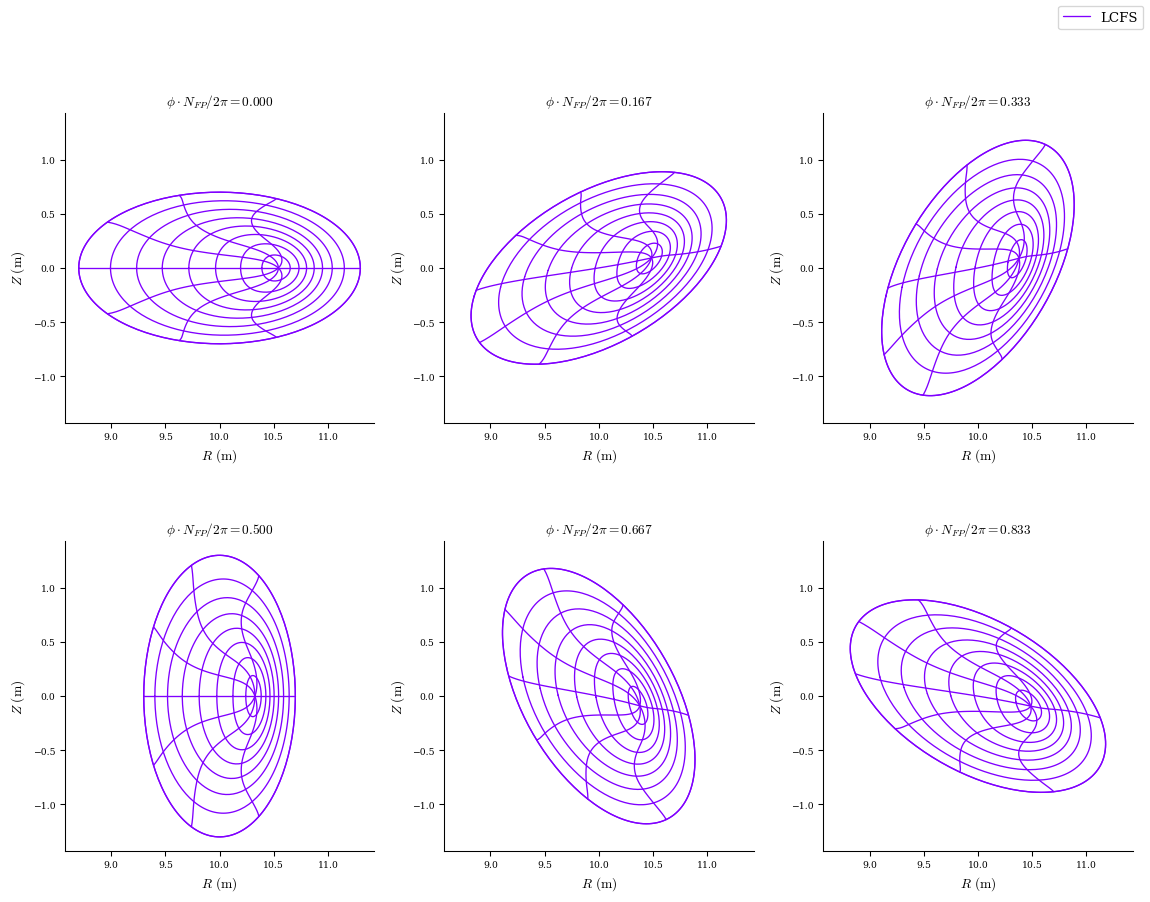

In [7]:
eq = get("HELIOTRON")

constraints = get_fixed_boundary_constraints(eq)
objective = ObjectiveFunction(ForceBalance(eq))
optimizer = Optimizer("lsq-exact")

eq.solve(verbose=3, ftol=0, objective=objective, constraints=constraints, optimizer=optimizer,maxiter=1, xtol=0)
plot_comparison(eqs=[eq],labels=['LCFS']);

### Creating a new Poincare surface to fix 

We can also create a new surface object called "PoincareRZLSection" to set our optimization problem as LCFS.

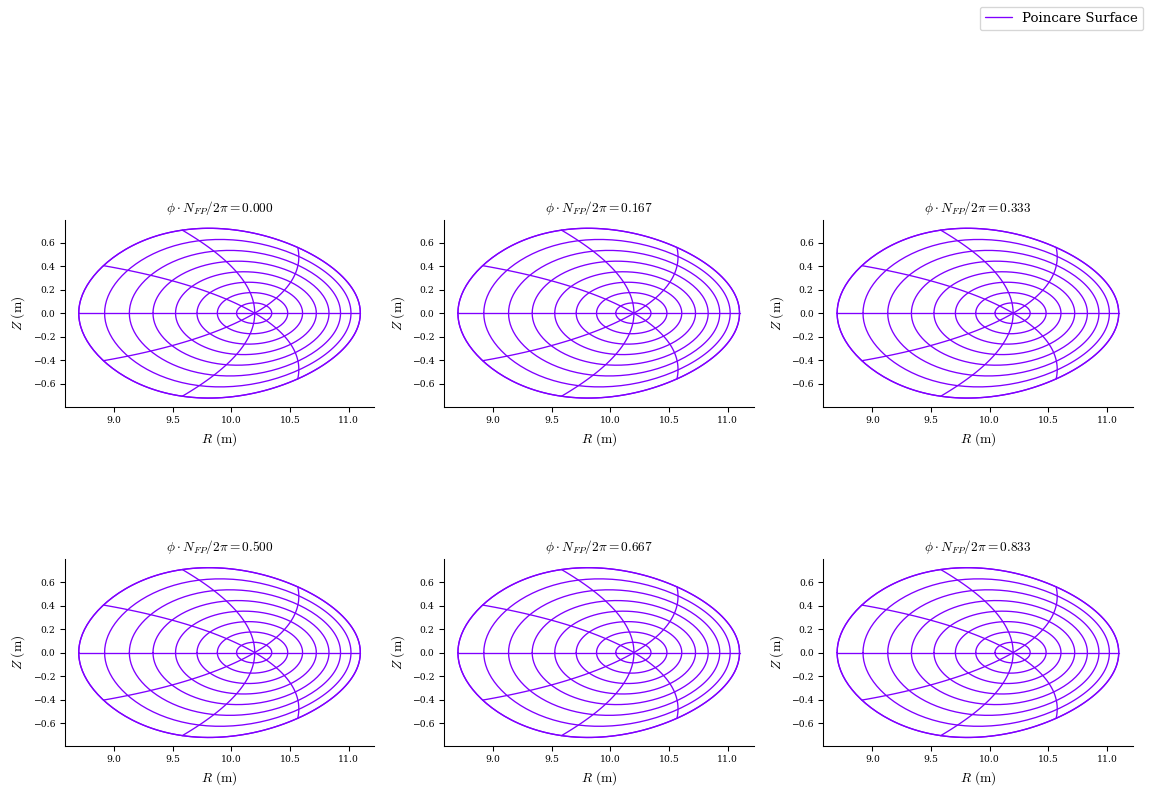

In [8]:
R_lmn = np.array([10, -1.2, -0.2, 0.1])
modes_R = np.array([[0, 0], [1, 1], [2, 0], [2, 2]])

Z_lmn = np.array([0.7, -0.04, -0.02])
modes_Z = np.array([[1, -1], [2, -2], [3, -3]])

L_lmn = np.array([.1])
modes_L = np.array([[1, -1]])

section = PoincareRZLSection(R_lmn=R_lmn, modes_R=modes_R,Z_lmn=Z_lmn, modes_Z=modes_Z,L_lmn=L_lmn, modes_L=modes_L)

eq_poincare = Equilibrium(
            xsection=section,
            pressure=0,
            iota=0,
            Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
            NFP=10,  # number of field periods
            L=5,  # radial spectral resolution
            M=5,  # poloidal spectral resolution
            N=4,  # toroidal spectral resolution
            L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
            M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
            N_grid=eq.N_grid,  # real space toroidal resolution
            sym=True,  # explicitly enforce stellarator symmetry
            spectral_indexing=eq._spectral_indexing,
        )

plot_comparison(eqs=[eq_poincare],labels=['Poincare Surface']);